In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import statistics
import pandas as pd
%matplotlib inline

In [2]:
## basic read in

In [3]:
def max_acc_point(acc_list):
    acc_point = np.argmax(acc_list)
    return acc_point

In [4]:
def min_loss_point(loss_list):
    loss_point = np.argmin(loss_list)
    return loss_point

In [5]:
def index_less_than(mylist,myvalue,value2):
    for i in range(len(mylist)):
        if mylist[i]<myvalue:
            if mylist[i]>0.78:
                return len(mylist)-1
            else:
                return i
    return len(mylist)-1

In [6]:
def es_point(acc_list,p): # p means steps after the max index
    max_num = 0
    count = 0
    for i in range(len(acc_list)):
        if acc_list[i]>max_num:
            max_num = acc_list[i]
            count = 0
        count = count+1
        if count>p:
            return i-1
    return int(len(acc_list)-1)

In [7]:
def windowed(s,half_window): # s is a list
    s_mean=[]
    s_var=[]
    window_size = half_window*2 + 1
    for i in range(len(s)-window_size+1):
        k = i + half_window 
        s_sub=s[k-half_window:k+half_window+1]
        sub_mean=sum(s_sub)/len(s_sub)
        s_mean.append(sub_mean)
        sub_var=statistics.variance(s_sub)
        s_var.append(sub_var)
    return s_mean,s_var

In [8]:
def read_acc_mean(files,i,speed=1):
    fileset = pd.concat( [pd.read_csv(f,header=None,sep=' ',names=['loss','acc'])['acc'] for f in files], axis=1)
    normalset = pd.concat( [fileset.iloc[:,i] for i in range(len(fileset.columns)) if fileset.iloc[:,i].isnull().any()==False], axis=1)
    normalset_mean = normalset.mean(axis=1).dropna()
    if speed==1:
        return normalset_mean   
    delayset = pd.concat( [fileset.iloc[:,i] for i in range(len(fileset.columns)) if fileset.iloc[:,i].isnull().any()==True], axis=1)
    delayset_mean = delayset.mean(axis=1).dropna()
    return normalset_mean,delayset_mean
def read_loss_mean(files,i,speed=1):
    fileset = pd.concat( [pd.read_csv(f,header=None,sep=' ',names=['loss','acc'])['loss'] for f in files], axis=1)
    normalset = pd.concat( [fileset.iloc[:,i] for i in range(len(fileset.columns)) if fileset.iloc[:,i].isnull().any()==False], axis=1)
    normalset_mean = normalset.mean(axis=1).dropna()
    if speed==1:
        return normalset_mean   
    delayset = pd.concat( [fileset.iloc[:,i] for i in range(len(fileset.columns)) if fileset.iloc[:,i].isnull().any()==True], axis=1)
    delayset_mean = delayset.mean(axis=1).dropna()
    return normalset_mean,delayset_mean

In [9]:
## how to plot

In [10]:
def plot_line(i,k,basedir,result,lab,addon=''):
    s1=np.load(os.path.join(basedir,result[k]))
    p=1000
    s1_epo = [i+1 for i in s1[0][:p]]
    ax[i].plot(s1_epo,s1[2][:p], label=lab[k]+addon)

In [11]:
def plot_window_acc(i,k,half_window,basedir,result,lab,line_color,dot_color,addon=''):
    s1=np.load(os.path.join(basedir,result[k]))
    p=1000
    
    (s_mean,s_varience)=windowed(s1[2][:p],half_window)

    s_epo=[i+half_window+1 for i in range(len(s_mean))]
    ax[i].plot(s_epo,s_mean, label=lab[k]+addon,color = line_color) # can also plot s_varience if want
    
    (s_loss,_)=windowed(s1[1][:p],half_window)
    
    index_min_loss = min_loss_point(s_loss)
    ax[i].plot(index_min_loss+half_window+1,s_mean[index_min_loss],dot_color)
    
    
#     # for bad node only
#     index_min_loss = min_loss_point(s_loss)
#     index_min_acc = min_loss_point(s_mean[index_min_loss:])+index_min_loss
#     min_acc = s_mean[index_min_acc]
#     index_less_than_nb = index_less_than(s_mean[index_min_loss:],min_acc+0.025,1)+index_min_loss
#     acc_drop = s_mean[index_less_than_nb]
#     ax[i].scatter(index_less_than_nb,acc_drop,c='k')
    

#     index_max=np.argmax(s_mean)
#     ax[i].plot(index_max,s_mean[index_max],dot_color)


In [12]:
def plot_file_acc(i,k,basedir,node_dir,lab,speed=1,filename='self_EVAL.txt'):
    files = glob.glob(basedir +'/'+ node_dir[k]+ '/worker_nodes/*/'+filename)
    linelab = lab[k]
    if speed==1:
        normalset_mean = read_acc_mean(files,i,speed)
        set_plt = [i+1 for i in range(len(normalset_mean))]
        ax[i].plot(set_plt,normalset_mean, label=linelab+'_t')
#         print('only usual')
        
    else:
        normalset_mean,delayset_mean = read_acc_mean(files,i,speed)
        
        normal_plt = [i+1 for i in range(len(normalset_mean))]
        ax[i].plot(normal_plt,normalset_mean, label=linelab+'_usual')
        
        new_delay_set = [val for val in delayset_mean for _ in range(speed)]
        delay_plt = [i+1 for i in range(len(new_delay_set))]
        ax[i].plot(delay_plt,new_delay_set, label=linelab+'_delay')

In [13]:
def plot_file_window_acc(i,k,half_window,basedir,node_dir,lab,speed=1,filename='self_EVAL.txt'):
    files = glob.glob(basedir +'/'+ node_dir[k]+ '/worker_nodes/*/'+filename)
    linelab = lab[k]
    if speed==1:
        normalset_mean = read_acc_mean(files,i,speed)
        (s_mean,s_varience)=windowed(normalset_mean,half_window)
        s_epo=[i+half_window+1 for i in range(len(s_mean))]
        ax[i].plot(s_epo,s_mean, label=linelab+'_t')
    else:
        normalset_mean,delayset_mean = read_acc_mean(files,i,speed)

        (s_mean,s_varience)=windowed(normalset_mean,half_window)
        s_epo=[i+half_window+1 for i in range(len(s_mean))]
        ax[i].plot(s_epo,s_mean, label=linelab+'_usual')
        
        new_delay_set = [val for val in delayset_mean for _ in range(speed)]
        (s_mean,s_varience)=windowed(new_delay_set,half_window)
        s_epo=[i+half_window+1 for i in range(len(s_mean))]
        ax[i].plot(s_epo,s_mean, label=linelab+'_delay')


## Poison Data

In [14]:
basedir=os.path.join('RESULT_4000/ShareData')
# os.listdir(basedir)

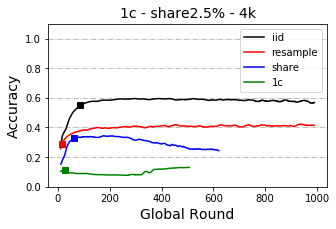

In [15]:
half_window = 10

s1=np.load(os.path.join('RESULT_4000/ShareData','iid.10w.4000.share100.loc1.earlystop500.20200505-111139.npy'))
(s_mean,s_varience)=windowed(s1[2][:1000],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,label = 'iid',color='k') 
(s_loss,_)=windowed(s1[1][:1000],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'ks')


s1=np.load(os.path.join('RESULT_4000/ShareData','1c.10w.4000.share100_epoiid.loc1.earlystop500.20200505-052608.npy'))
(s_mean,s_varience)=windowed(s1[2][:1000],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,label = 'resample',color='r') 
(s_loss,_)=windowed(s1[1][:1000],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'rs')

s1=np.load(os.path.join('RESULT_4000/ShareData','1c.10w.4000.share100.loc1.earlystop500.20200504-211245.npy'))
(s_mean,s_varience)=windowed(s1[2][:1000],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,label = 'share',color='b') 
(s_loss,_)=windowed(s1[1][:1000],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'bs')

s1=np.load(os.path.join('RESULT_4000/Pilot_classes','1c.10w.4000.loc1.earlystop500.20200510-163959.npy'))
(s_mean,s_varience)=windowed(s1[2][:1000],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,label = '1c',color='g') 
(s_loss,_)=windowed(s1[1][:1000],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'gs')


plt.gcf().set_size_inches(5, 3)

plt.title('1c - share2.5% - 4k',fontsize=14)
plt.ylabel('Accuracy',fontsize=14) 
plt.ylim([0, 1.1])    
plt.xlabel('Global Round',fontsize=14)      
plt.grid(axis="y",ls='-.')
plt.legend()

In [16]:
basedir=os.path.join('RESULT_40000/new_sd')
os.listdir(basedir)

['40k_1c_share',
 '40k_1c_share.npy',
 '40k_1c_undersample',
 '40k_1c_undersample.npy']

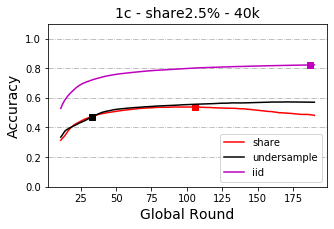

In [24]:
half_window = 10

s1=np.load(os.path.join('RESULT_40000/new_sd','40k_1c_share.npy'))
(s_mean,s_varience)=windowed(s1[2][:1000],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,label = 'share',color='r') 
(s_loss,_)=windowed(s1[1][:1000],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'rs')

s1=np.load(os.path.join('RESULT_40000/new_sd','40k_1c_undersample.npy'))
(s_mean,s_varience)=windowed(s1[2][:1000],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,label = 'undersample',color='k') 
(s_loss,_)=windowed(s1[1][:1000],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'ks')


s1=np.load(os.path.join('RESULT_40000/LocalStep','iid.10w.40000.loc1.earlystop1000.20200521-172951.npy'))
(s_mean,s_varience)=windowed(s1[2][:200],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,label = 'iid',color='m') 
(s_loss,_)=windowed(s1[1][:200],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'ms')


plt.gcf().set_size_inches(5, 3)

plt.title('1c - share2.5% - 40k',fontsize=14)
plt.ylabel('Accuracy',fontsize=14) 
plt.ylim([0, 1.1])    
plt.xlabel('Global Round',fontsize=14)      
plt.grid(axis="y",ls='-.')
plt.legend()

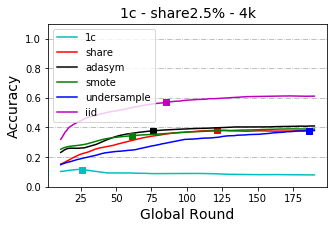

In [51]:
half_window = 10

s1=np.load(os.path.join('RESULT_4000/Pilot_classes','1c.10w.4000.loc1.earlystop500.20200510-163959.npy'))
(s_mean,s_varience)=windowed(s1[2][:200],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,label = '1c',color='c') 
(s_loss,_)=windowed(s1[1][:200],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'cs')

s1=np.load(os.path.join('RESULT_4000/new_sharedata','1c_share.npy'))
(s_mean,s_varience)=windowed(s1[2][:1000],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,label = 'share',color='r') 
(s_loss,_)=windowed(s1[1][:1000],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'rs')

s1=np.load(os.path.join('RESULT_4000/new_sharedata','1c_adasym.npy'))
(s_mean,s_varience)=windowed(s1[2][:1000],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,label = 'adasym',color='k') 
(s_loss,_)=windowed(s1[1][:1000],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'ks')

s1=np.load(os.path.join('RESULT_4000/new_sharedata','1c_smote.npy'))
(s_mean,s_varience)=windowed(s1[2][:1000],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,label = 'smote',color='g') 
(s_loss,_)=windowed(s1[1][:1000],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'gs')

s1=np.load(os.path.join('RESULT_4000/new_sharedata','1c_undersample.npy'))
(s_mean,s_varience)=windowed(s1[2][:1000],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,label = 'undersample',color='b') 
(s_loss,_)=windowed(s1[1][:1000],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'bs')

s1=np.load(os.path.join('RESULT_4000/Pilot_classes','iid.10w.4000.loc1.earlystop500.20200501-020117.npy'))
(s_mean,s_varience)=windowed(s1[2][:200],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,label = 'iid',color='m') 
(s_loss,_)=windowed(s1[1][:200],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'ms')


plt.gcf().set_size_inches(5, 3)

plt.title('1c - share2.5% - 4k',fontsize=14)
plt.ylabel('Accuracy',fontsize=14) 
plt.ylim([0, 1.1])    
plt.xlabel('Global Round',fontsize=14)      
plt.grid(axis="y",ls='-.')
plt.legend()

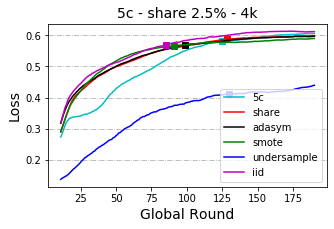

In [59]:
half_window = 10

s1=np.load(os.path.join('RESULT_4000/Pilot_classes','5c.10w.4000.loc1.earlystop500.20200501-024326.npy'))
(s_mean,s_varience)=windowed(s1[2][:200],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,label = '5c',color='c') 
(s_loss,_)=windowed(s1[1][:200],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'cs')

s1=np.load(os.path.join('RESULT_4000/new_sharedata','5c_share.npy'))
(s_mean,s_varience)=windowed(s1[2][:1000],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,label = 'share',color='r') 
(s_loss,_)=windowed(s1[1][:1000],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'rs')

s1=np.load(os.path.join('RESULT_4000/new_sharedata','5c_adasym.npy'))
(s_mean,s_varience)=windowed(s1[2][:1000],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,label = 'adasym',color='k') 
(s_loss,_)=windowed(s1[1][:1000],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'ks')

s1=np.load(os.path.join('RESULT_4000/new_sharedata','5c_smote.npy'))
(s_mean,s_varience)=windowed(s1[2][:1000],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,label = 'smote',color='g') 
(s_loss,_)=windowed(s1[1][:1000],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'gs')

s1=np.load(os.path.join('RESULT_4000/new_sharedata','5c_undersample.npy'))
(s_mean,s_varience)=windowed(s1[2][:1000],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,label = 'undersample',color='b') 
(s_loss,_)=windowed(s1[1][:1000],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'bs')

s1=np.load(os.path.join('RESULT_4000/Pilot_classes','iid.10w.4000.loc1.earlystop500.20200501-020117.npy'))
(s_mean,s_varience)=windowed(s1[2][:200],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,label = 'iid',color='m') 
(s_loss,_)=windowed(s1[1][:200],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'ms')

plt.gcf().set_size_inches(5, 3)

plt.title('1c - share2.5% - 4k',fontsize=14)
plt.ylabel('Accuracy',fontsize=14) 
# plt.ylim([0, 1.1])    
plt.xlabel('Global Round',fontsize=14)      
plt.grid(axis="y",ls='-.')
plt.legend()


plt.gcf().set_size_inches(5, 3)

plt.title('5c - share 2.5% - 4k',fontsize=14)
plt.ylabel('Loss',fontsize=14) 
# plt.ylim([0, 1.1])    
plt.xlabel('Global Round',fontsize=14)      
plt.grid(axis="y",ls='-.')
plt.legend()

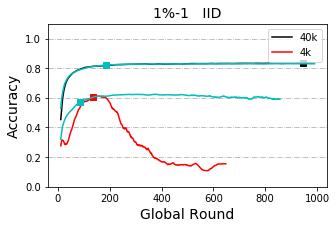

In [18]:
half_window = 10

s1=np.load(os.path.join('RESULT_40000/BadNode','iid.10w.40000.plus1bad_each400.loc1.earlystop1000.20200521-185542.npy'))
(s_mean,s_varience)=windowed(s1[2][:1000],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,label = '40k',color='k') 
(s_loss,_)=windowed(s1[1][:1000],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'ks')



s1=np.load(os.path.join('RESULT_4000/BadNode','11d.10w.4000.plus1bad_each40.loc1.earlystop500.20200501-020918.npy'))
(s_mean,s_varience)=windowed(s1[2][:1000],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,label = '4k',color='r') 
(s_loss,_)=windowed(s1[1][:1000],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'rs')


s1=np.load(os.path.join('RESULT_40000/BadNode','iid.10w.40000.loc1.earlystop1000.20200521-172951.npy'))
(s_mean,s_varience)=windowed(s1[2][:1000],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,color='c') 
(s_loss,_)=windowed(s1[1][:1000],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'cs')



s1=np.load(os.path.join('RESULT_4000/BadNode','iid.10w.4000.loc1.earlystop500.20200501-020117.npy'))
(s_mean,s_varience)=windowed(s1[2][:1000],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,color='c') 
(s_loss,_)=windowed(s1[1][:1000],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'cs')




plt.gcf().set_size_inches(5, 3)

plt.title('1%-1   IID',fontsize=14)
plt.ylabel('Accuracy',fontsize=14) 
plt.ylim([0, 1.1])    
plt.xlabel('Global Round',fontsize=14)      
plt.grid(axis="y",ls='-.')
plt.legend()

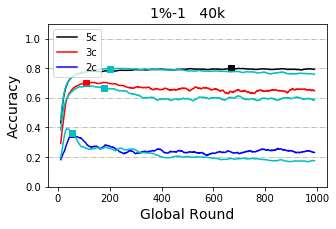

In [19]:
half_window = 10

s1=np.load(os.path.join('RESULT_40000/BadNode','5c.10w.40000.plus1bad_each400.loc1.earlystop1000.20200521-152400.npy'))
(s_mean,s_varience)=windowed(s1[2][:1000],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,label = '5c',color='k') 
(s_loss,_)=windowed(s1[1][:1000],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'ks')


s1=np.load(os.path.join('RESULT_40000/BadNode','3c.10w.40000.plus1bad_each400.loc1.earlystop1000.20200523-043427.npy'))
(s_mean,s_varience)=windowed(s1[2][:1000],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,label = '3c',color='r') 
(s_loss,_)=windowed(s1[1][:1000],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'rs')

s1=np.load(os.path.join('RESULT_40000/BadNode','2c.10w.40000.plus1bad_each400.loc1.earlystop1000.20200521-150153.npy'))
(s_mean,s_varience)=windowed(s1[2][:1000],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,label = '2c',color='b') 
(s_loss,_)=windowed(s1[1][:1000],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'bs')


s1=np.load(os.path.join('RESULT_40000/BadNode','5c.10w.40000.loc1.earlystop1000.20200521-171047.npy'))
(s_mean,s_varience)=windowed(s1[2][:1000],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,color='c') 
(s_loss,_)=windowed(s1[1][:1000],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'cs')


s1=np.load(os.path.join('RESULT_40000/BadNode','3c.10w.40000.loc1.earlystop1000.20200523-042344.npy'))
(s_mean,s_varience)=windowed(s1[2][:1000],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,color='c') 
(s_loss,_)=windowed(s1[1][:1000],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'cs')

s1=np.load(os.path.join('RESULT_40000/BadNode','2c.10w.40000.loc1.earlystop1000.20200521-163612.npy'))
(s_mean,s_varience)=windowed(s1[2][:1000],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,color='c') 
(s_loss,_)=windowed(s1[1][:1000],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'cs')




plt.gcf().set_size_inches(5, 3)

plt.title('1%-1   40k',fontsize=14)
plt.ylabel('Accuracy',fontsize=14) 
plt.ylim([0, 1.1])    
plt.xlabel('Global Round',fontsize=14)      
plt.grid(axis="y",ls='-.')
plt.legend()